<table align="left">
  <tr>
    <td>
      <!-- Crest Image -->
      <img src="https://mastergardener.extension.wisc.edu/wp-content/themes/ext-discovery/images/uw-crest-web.png" width="53" height="85" style="margin-right: 15px;">
    </td>
    <td>
      <!-- Title and Subtitle -->
      <div>
        <h1 style="color: #c5050c; font-size: 28px; margin: 0;">Data Science in Human Behavior</h1>
        <p style="color: #282728; font-size: 16px; margin: 0;">Master of Science</p>
      </div>
    </td>
  </tr>
  <tr>
    <td></td>
    </tr>
  </tr>
  <tr>

  </tr>
</table>

In [ ]:
# Import Pandas, Seaborn, and related
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, classification_report

# Set the Seaborn context
sns.set_context('talk')

In [ ]:
# Check For Available CSV Data Files
!pip install ucimlrepo

In [ ]:
# Record the current working directory
print(os.getcwd())

/content


# Step 1.10 Load & Inspect Data

In [ ]:
df = pd.read_csv('workout_data-2.csv')

In [ ]:
# Periodic, routine check of data set obs and column count
obs, cols = df.shape     # Tuple unpack to get df dimaions

print(obs)               # Refactor with f-string for more readable output
print(cols)              # Refactor with f-string for more readable output

1000
9


In [ ]:
# Check the head, tail, or sample here (and periodically below)
df.sample(5)

,workout_id,workout_type,workout_intensity,spotter_help,weight_lbs,workout_duration,repetitions,sweat_ratio,workout_effort
585,1585,Bench Press,Low,Yes,105,16.311046,3,6.44,79.50
269,1269,Squat,High,Yes,150,11.703168,16,12.82,77.23
160,1160,Squat,High,Yes,140,14.774642,11,9.48,60.25
880,1880,Barbell Row,High,No,85,14.028310,11,6.06,81.33
469,1469,Barbell Row,High,Yes,235,11.514201,3,20.41,77.20


In [ ]:
# Eliminate Unecessary Columns (such as id variables)
df.drop(columns=['workout_id'], inplace=True)

In [ ]:
# Check the head, tail, or sample (usually after df modificaitons)
df.sample(5)

,workout_type,workout_intensity,spotter_help,weight_lbs,workout_duration,repetitions,sweat_ratio,workout_effort
967,Incline Bench,High,Yes,180,6.356462,3,28.32,71.97
659,Barbell Row,High,Yes,145,9.342816,13,15.52,73.64
930,Squat,Low,No,160,11.067744,18,14.46,69.70
85,Incline Bench,High,Yes,195,2.897470,13,67.30,71.44
470,Bench Press,Medium,No,120,13.191006,17,9.10,63.73


In [ ]:
# Periodic, routine check of data set obs and column count
obs, cols = df.shape          # Tuple unpack to get df dimaions
print(f'There are {obs} observations and there are {cols} columns.')

There are 1000 observations and there are 8 columns.


<Axes: >

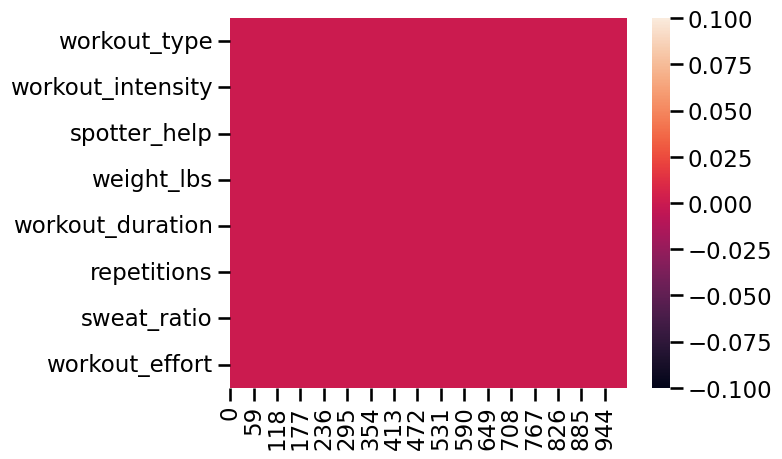

In [ ]:
# Check for missing data using visual heatmap
sns.heatmap(df.isnull().transpose())

In [ ]:
# Check for missing data using method chain
df.isnull().mean().apply(lambda x: f'{x * 100}% Missing')

,0
workout_type,0.0% Missing
workout_intensity,0.0% Missing
spotter_help,0.0% Missing
weight_lbs,0.0% Missing
workout_duration,0.0% Missing
repetitions,0.0% Missing
sweat_ratio,0.0% Missing
workout_effort,0.0% Missing


In [ ]:
# Periodic, routine check of column names
df.columns

Index(['workout_type', 'workout_intensity', 'spotter_help', 'weight_lbs',
       'workout_duration', 'repetitions', 'sweat_ratio', 'workout_effort'],
      dtype='object')

In [ ]:
non_binary_cols = []
for i in df.columns:
  if df[i].nunique() !=2:
    non_binary_cols.append(i)
print(non_binary_cols)

['workout_type', 'workout_intensity', 'weight_lbs', 'workout_duration', 'repetitions', 'sweat_ratio', 'workout_effort']


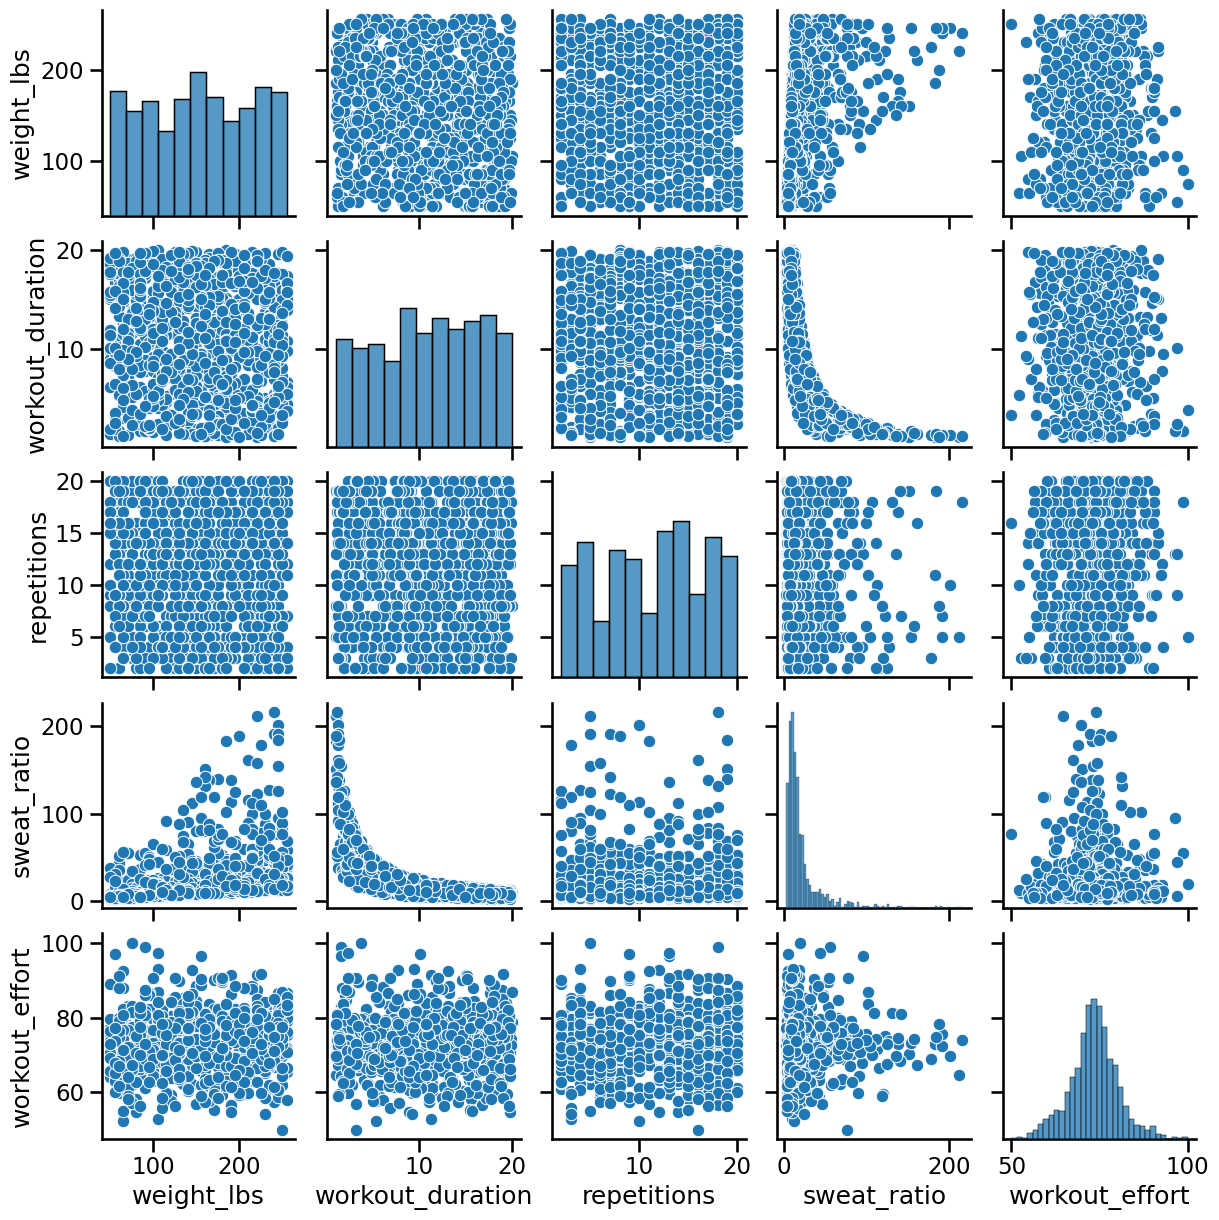

In [ ]:
# Inspect a pair plot (for continuous data)
sns.pairplot(df)

In [ ]:
# Inspect Chi2 relationships (for categorical data)
cat_cols = [c for c in df.columns if df[c].nunique() < 15][::-1]
cat_p_values = []
for c1 in cat_cols:
  for c2 in cat_cols:
    cat_p_values.append(
    round(
      chi2_contingency(pd.crosstab(df[c1], df[c2]))[1], 5))

chi2_table = pd.DataFrame(
  np.array(cat_p_values).reshape(len(cat_cols), len(cat_cols)),
  index=cat_cols, columns=cat_cols)
chi2_table

,spotter_help,workout_intensity,workout_type
spotter_help,0.00000,0.75356,0.64928
workout_intensity,0.75356,0.00000,0.75103
workout_type,0.64928,0.75103,0.00000


# Step 1.20 (a) Prepare a Target Variable

For some data the target variable *as is* will be read to go.

In [ ]:
df['spotter_help_binary'] = df['spotter_help'].apply(lambda x: 1 if x == 'Yes' else 0)
df['spotter_help_binary'].describe()


,spotter_help_binary
count,1000.00000
mean,0.49000
std,0.50015
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


In [ ]:
#make high intensity 3,medium 2, low 1
df['workout_intensity_cat'] = df['workout_intensity'].apply(lambda x: 3 if x == 'High' else 2 if x == 'Medium' else 1)
df['workout_intensity_cat'].describe()

,workout_intensity_cat
count,1000.000000
mean,1.999000
std,0.815883
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


In [ ]:
fig, axes = plt.subplots(
    nrows=7, ncols=1, figsize=(10, 21),
    constrained_layout=True)

for ax, c in zip(axes, non_binary_cols):
  sns.violinplot(data=df,
              y='spotter_help_binary',
              x=c,
              ax=ax,
              orient='h')
  ax.set_title(f'Box plot of {c} and Spotter Assist')

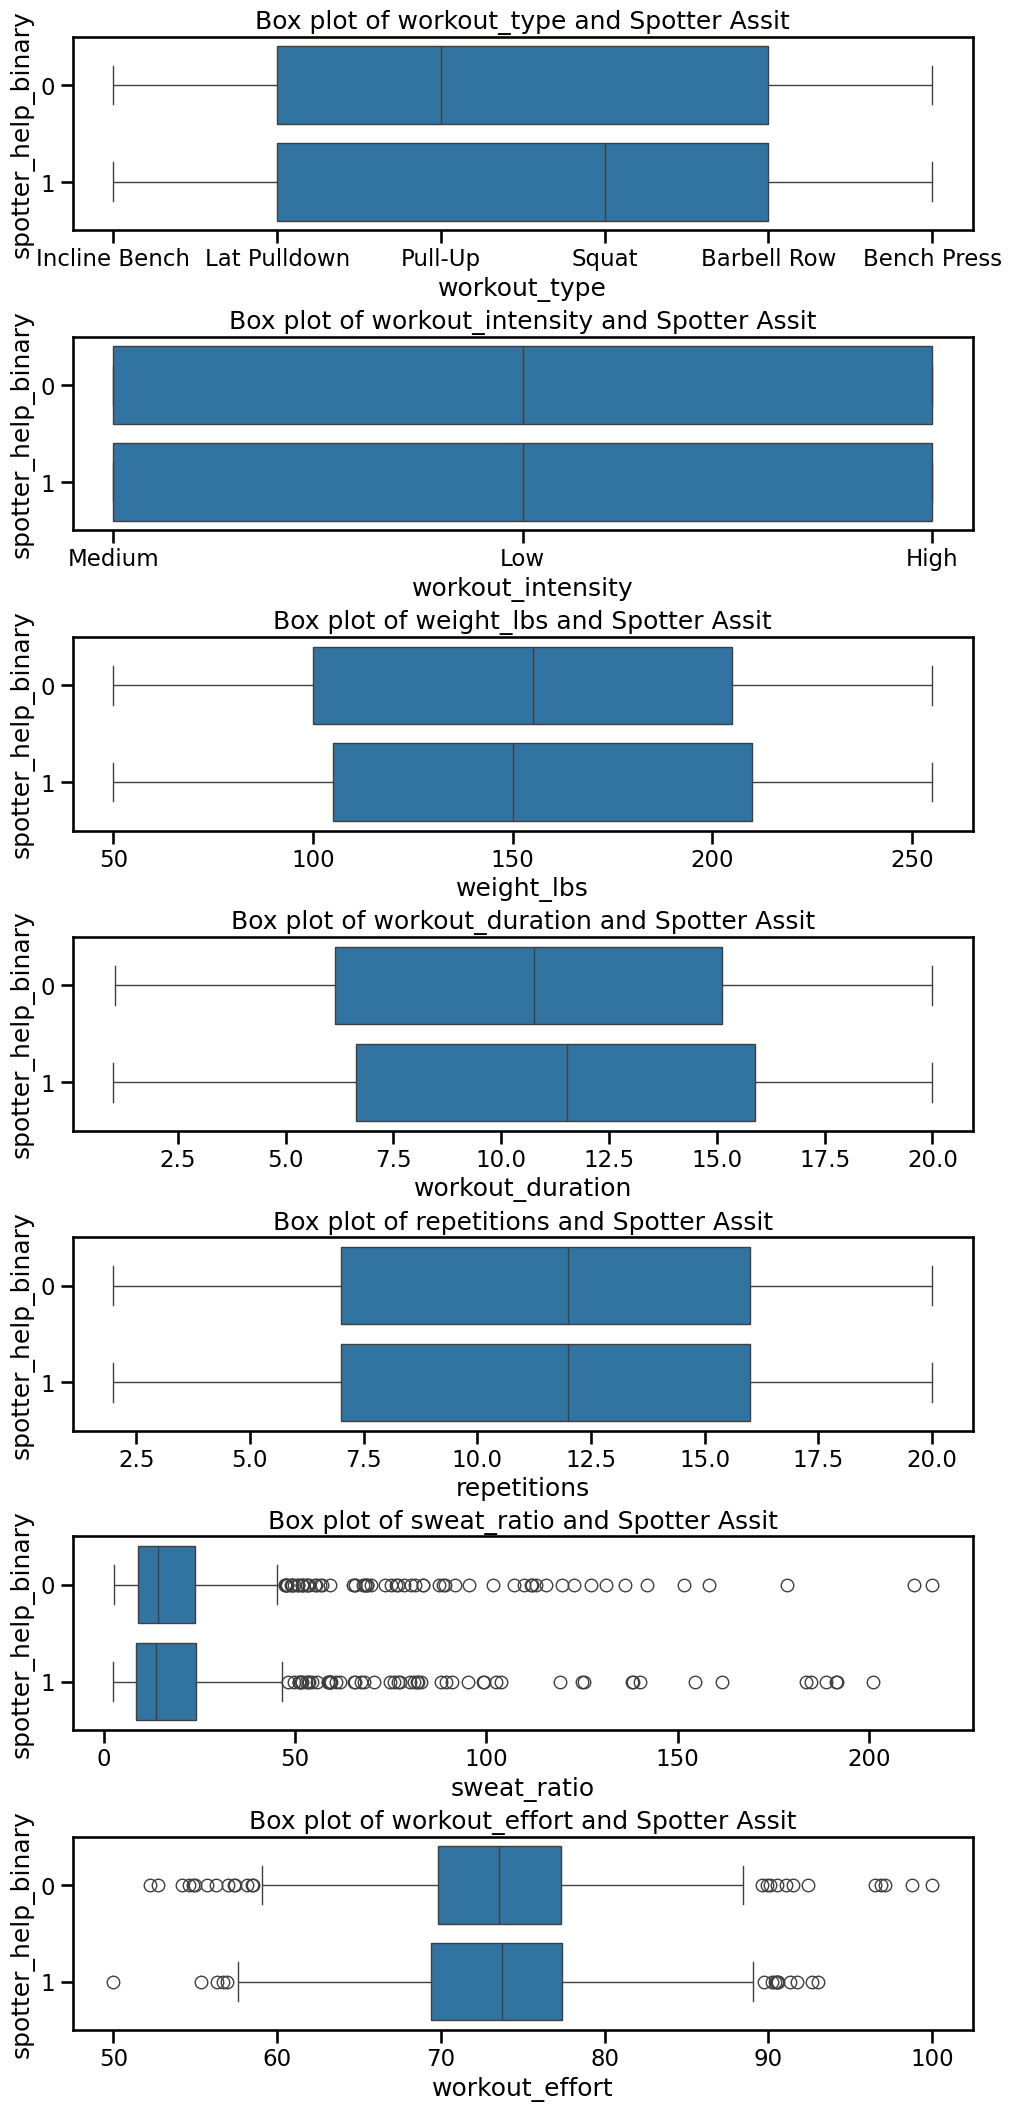

In [ ]:
fig, axes = plt.subplots(
    nrows=7, ncols=1, figsize=(10, 21),
    constrained_layout=True)

for ax, c in zip(axes, non_binary_cols):
  sns.boxplot(data=df,
              y='spotter_help_binary',
              x=c,
              ax=ax,
              orient='h')
  ax.set_title(f'Box plot of {c} and Spotter Assit')

In [ ]:
from scipy.stats import ttest_ind
numeric_cols = df[non_binary_cols].select_dtypes(include=np.number).columns.tolist()

for c in numeric_cols:
  t_stat, p_value = ttest_ind(
      df[df['spotter_help_binary'] == 0][c],
      df[df['spotter_help_binary'] == 1][c],
      equal_var=False)
  print(f'When comparing spotting assist with {c} via t-test we see:')
  print(f'T-stat = {t_stat}, and p-value = {p_value}')
  print('')

# Step 1.20 (b) Prepare Predictor Features

In [ ]:
df[['spotter_help_binary','workout_intensity_cat','workout_duration',
    'repetitions', 'weight_lbs']].sample(3)

In [ ]:
df[['spotter_help_binary','workout_intensity_cat','workout_duration',
    'repetitions', 'weight_lbs']].describe().T

In [ ]:
df.columns

In [ ]:
# Instantiate encoders and scalers
scaler = MinMaxScaler().set_output(transform='pandas')

ohe = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore').set_output(transform='pandas')

In [ ]:
# Rescale continuous variables

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
# Following data modification check head, tail, or sample
df[['spotter_help_binary','workout_intensity_cat','workout_duration',
    'repetitions', 'weight_lbs']].sample(3)

In [ ]:
# One hot encode categorical variables
df = df.join(ohe.fit_transform(df[['workout_intensity_cat']]))


In [ ]:
# Following data modification check head, tail, or sample
df.sample(3)

In [ ]:
# Remove original categorical columns
df = df.drop(columns=['workout_intensity_cat'])

In [35]:
# Following data modification check head, tail, or sample
df.sample(3)

,workout_type,workout_intensity,spotter_help,weight_lbs,workout_duration,repetitions,sweat_ratio,workout_effort,spotter_help_binary,workout_intensity_cat_1,workout_intensity_cat_2,workout_intensity_cat_3
628,Barbell Row,Low,No,0.878049,0.414130,0.333333,0.109080,0.3012,0,1.0,0.0,0.0
201,Incline Bench,High,Yes,0.829268,0.213706,0.388889,0.190901,0.5022,1,0.0,0.0,1.0
291,Bench Press,High,No,0.658537,0.459973,0.166667,0.076632,0.4624,0,0.0,0.0,1.0


In [36]:
# Periodic, routine check of data set obs and column count
obs, cols = df.shape          # Tuple unpack to get df dimaions
print(f'There are {obs} observations + there are {cols} columns.')

There are 1000 observations + there are 12 columns.


In [37]:
# Periodic, routine check of column names
df.columns
df.drop(columns=['workout_intensity', 'spotter_help'], inplace=True)

In [38]:
# Check to make sure that all columns are numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   workout_type             1000 non-null   object 
 1   weight_lbs               1000 non-null   float64
 2   workout_duration         1000 non-null   float64
 3   repetitions              1000 non-null   float64
 4   sweat_ratio              1000 non-null   float64
 5   workout_effort           1000 non-null   float64
 6   spotter_help_binary      1000 non-null   int64  
 7   workout_intensity_cat_1  1000 non-null   float64
 8   workout_intensity_cat_2  1000 non-null   float64
 9   workout_intensity_cat_3  1000 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 78.3+ KB


# 1.30 Train Test Split

In [39]:
# Establish the feature matrix
X = df[['workout_intensity_cat_3','workout_duration',
    'repetitions', 'weight_lbs']]
# Establish the target matrix
y = df['spotter_help_binary']

In [40]:
# Pass feature and target matrix into sklearn’s train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

# 1.40 Build + Evaluate Base Model

In [41]:
# Instantiate a base (knn) classifier

# Find predictions based on the trained model
base_knn = KNeighborsClassifier(n_neighbors=5)
#Fitting / training the model
base_knn.fit(X_train, y_train)

y_pred = base_knn.predict(X_test)

In [42]:
# Check proportion of matching predictions
(y_pred == y_test)

,spotter_help_binary
89,True
844,True
417,True
117,True
864,False
...,...
689,False
154,True
708,True
996,True


In [43]:
# Check the proportion of mismatches (error rate)

(y_pred != y_test).mean()

np.float64(0.4575757575757576)

In [44]:
# Check the confusion matrix results
pd.crosstab(y_pred, y_test, margins=True)

spotter_help_binary,0,1,All
row_0,,,
0,106,89,195
1,62,73,135
All,168,162,330


# 1.50 Check For Optimal K

In [45]:
# Instantiating a list of error rates
error_rates = []

search_range = list(range(1, 99, 2))

for k in search_range:
    # The KNN classification model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Generate predictions on the testing data
    y_pred_kn = knn.predict(X_test)
    # Calculate and record proprtion of correct classifications
    error_rates.append(np.mean(y_pred_kn != y_test))

Text(47, 0.4521212121212121, 'Best Error W/ Fewest K')

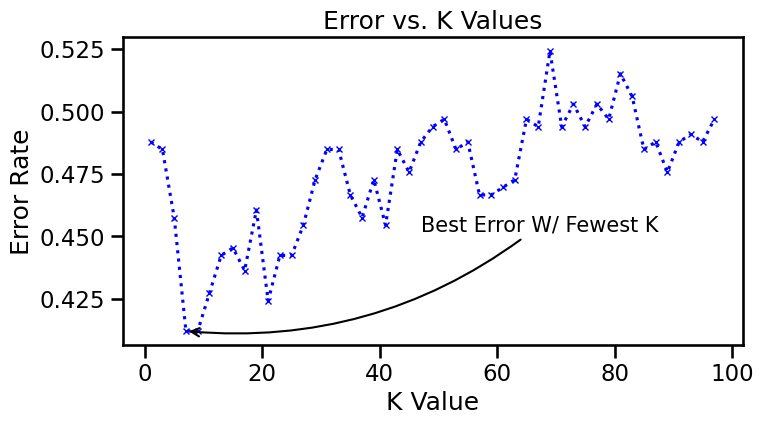

In [46]:
# Visualize the results of the search above
plt.figure(figsize=(8, 4))           # Landscape Sizing

# Match plot range to for loop above - add style for readability
plt.plot(search_range, error_rates, color='blue',
         linestyle=':', marker='x', markersize=5)

best_k = search_range[error_rates.index(min(error_rates))]
best_error_rate = min(error_rates)

plt.title('Error vs. K Values')      # Chart Title
plt.xlabel('K Value')                # X Axis Title
plt.ylabel('Error Rate')             # Y Axis Title

# The following annotations will not work unless you modify the xy
# arguments specifically for your results.

# xy = Coords to point at, xytext = Annotation placement
# arrowtyle = Arrowhead style (Other options include '-[', ']-', '<-')
# connectionstyle = Defines arrow path (curvature/other effects)
#                   rad = The radius of the curge
plt.annotate(text='Best Error W/ Fewest K', fontsize=15,
             xy=(best_k, best_error_rate), xytext=(best_k + 40, best_error_rate + .04),
             arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3, rad=-.2'})

# 1.60 Visualize Marginal Results

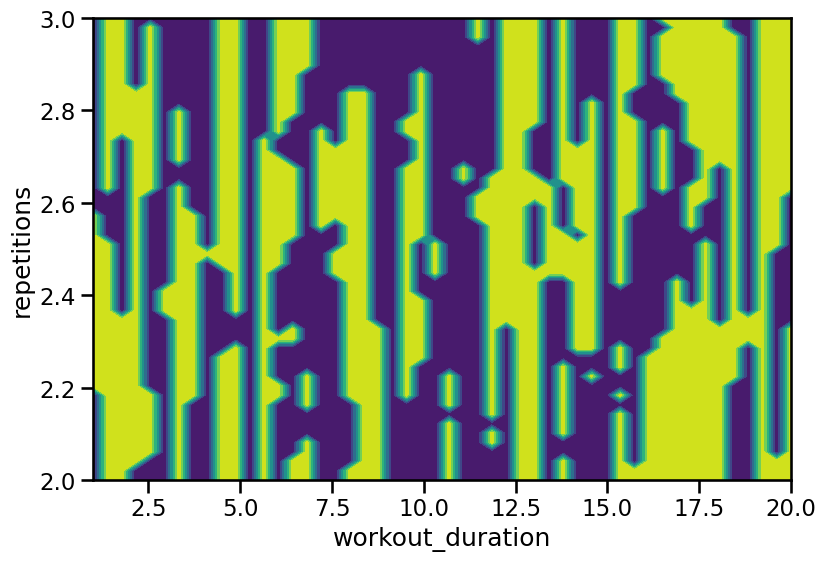

In [47]:
from sklearn.inspection import DecisionBoundaryDisplay

workout_duration_original_scale = (X_train['workout_duration'] - X_train['workout_duration'].min()) /(X_train['workout_duration'].max() - X_train['workout_duration'].min()) * (20 - 1) + 1
repetitions_original_scale = X_train['repetitions']- X_train['repetitions'].min() /(X_train['repetitions'].max() - X_train['repetitions'].min()) * (20 - 2) + 2

X_train_decision = pd.DataFrame({
    'workout_duration': workout_duration_original_scale,
    'repetitions': repetitions_original_scale
})

# Instantiate a classifier for this decision space visual
knn_decision_space = KNeighborsClassifier(n_neighbors=5)  # Use optimal K value
knn_decision_space.fit(X_train_decision, y_train)

fig, axes = plt.subplots(figsize=(9, 6))

d = DecisionBoundaryDisplay.from_estimator(
    knn_decision_space,
    X_train_decision,
    grid_resolution=50,
    response_method='predict',
    eps=0,
    ax=axes
)

plt.show()